<a href="https://colab.research.google.com/github/soumik0303/PythonTuts/blob/main/Zomato_Bengaluru_Restaurants_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'zomato-bangalore-restaurants:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F153420%2F352891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T080527Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7468352a49ae8136b31ff5c9a016975f58cdb3d42c5a632d08025b7865b1e3e1cef1ea6ddc937b30680141e6bfc816b4db2fa4fa6f873cac4806a935e7941db7497a9cb1c5b71c688c02ecfc4f7f5834691ec3c4b6cef04b25d12f88df96f9b9eace43041e5bbf07a103798827e8484c078db2ada26ae4118f2c166c233449d5bd6d1dc8893b9b80159d82606037ac888e21a38ce74ea5eb3e7c5f93d5a9ab8097a3ccddb4690faac600fa6a61424218820f73fc747be483880c97560586e7329938332d521c8c8fb54f38b2c1d3197cb96dcf028a57cdc9216587aaee5141b8e0c6b6b42a96877a843aef4f69f39a622e751d2e5626a5d1d79dfecbd0933345'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 93341357 bytes downloaded
Downloaded and uncompressed: zomato-bangalore-restaurants
Data source import complete.


#ZOMATO:-
Zomato is an Indian multinational restaurant aggregator and food delivery company.It was founded by Deepinder Goyan and Pankaj Chaddah in 2008.Zomato provides information,menus,user-reviews of restaurants as well as food delivery options from partner restaurants in more than 1000 Indian cities and towns,as of 2022-2023.

Here we will make an Exploratory Data Analysis on restaurants,partnered with Zomato in the city of Bengaluru.

#Import libraries and data:-

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
zomato_df = pd.read_csv('/kaggle/input/zomato-bangalore-restaurants/zomato.csv')
zomato_df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


The dataset needs to be observed now,we need to know the number of rows and columns of this dataset.

#Number of rows

In [ ]:
zomato_df.shape

(51717, 17)

So the dataset contains 51717 rows and 17 columns.After a quick view to the dataset we can say it's a typical Restaurant Data which are clearly partnered with zomato in Bengaluru.

#Observations on the shape of the data,datatype of all the attributes to category,missing value detection and statistical summary.

To get all the attributes

In [ ]:
zomato_df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

Shape of data

In [ ]:
zomato_df.shape

(51717, 17)

So it has 51717 rows and 17 columns and it is a 2D data frame.

Datatype of all the attributes

In [ ]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

Statistical summary before Data Cleaning

In [ ]:
zomato_df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


#Data profiling and Cleaning and also the missing value detection

Data cleaning means the process of identifying incorrect,inaccurate,incomplete,irrelevant or missing pieces of data then modifying,replacing and deleting them as needed.Data cleaning is considered as basic element of the data science.

In [ ]:
print('columns with missing values: ')
print(zomato_df.isnull().any())

columns with missing values: 
url                            False
address                        False
name                           False
online_order                   False
book_table                     False
rate                            True
votes                          False
phone                           True
location                        True
rest_type                       True
dish_liked                      True
cuisines                        True
approx_cost(for two people)     True
reviews_list                   False
menu_item                      False
listed_in(type)                False
listed_in(city)                False
dtype: bool


In [ ]:
zomato_df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [ ]:
 zomato_df.isnull().sum()/len(zomato_df)*100

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [ ]:
missing_values = pd.DataFrame(
     {
        'Null Count' : zomato_df.isnull().sum(),
        'percent(%)' : np.round(zomato_df.isnull().sum()/len(zomato_df)*100,2)
     }
)

In [ ]:
missing_values

,Null Count,percent(%)
url,0,0.00
address,0,0.00
name,0,0.00
online_order,0,0.00
book_table,0,0.00
rate,7775,15.03
votes,0,0.00
phone,1208,2.34
location,21,0.04
rest_type,227,0.44


In [ ]:
zomato_df.isnull().sum().sum()

37700

There are 37700 null values accross the entire dataset with 7775 missing points under 'rate',1208 under 'phone',21 under location,227 under 'rest_type',28078 under 'dish_liked',45 under cuisin and 346 under 'approx_cost'

#Imputation is a tretment method for missing value by filling it by using some certain techniques.

Can use mean,mode or use predictive modelling.In this case study we will use 'fillna' functions from pandas for this imputations.Drop rows containing missing values will be completed by 'dropna' function from pandas.

In [ ]:
#now we will drop some of the columns to reduce the complexity of the dataset,as we don't need these columns further.
zomato_df=zomato_df.drop(['url','address','phone','menu_item','dish_liked','reviews_list'],axis=1)
zomato_df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari


In [ ]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         51717 non-null  object
 1   online_order                 51717 non-null  object
 2   book_table                   51717 non-null  object
 3   rate                         43942 non-null  object
 4   votes                        51717 non-null  int64 
 5   location                     51696 non-null  object
 6   rest_type                    51490 non-null  object
 7   cuisines                     51672 non-null  object
 8   approx_cost(for two people)  51371 non-null  object
 9   listed_in(type)              51717 non-null  object
 10  listed_in(city)              51717 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.3+ MB


#Dropping Duplicates

In [ ]:
zomato_df.drop_duplicates(inplace=True)
zomato_df.shape

(51609, 11)

After dropping the duplicates we have got the final unique values

Cleaning the 'rate' column

In [ ]:
zomato_df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

Now we need to unnest the rating and convert the rating into float from the string

In [ ]:
def handlerate(value):
  if value=='NEW' or value=='-':
    return np.nan
  else:
    value=str(value).split('/')
    value=value[0]
    return float(value)

In [ ]:
zomato_df['rate']=zomato_df['rate'].apply(handlerate)
zomato_df['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

Filling null values in rate column with mean

In [ ]:
zomato_df['rate'].fillna(zomato_df['rate'].mean(),inplace=True)
zomato_df.isnull().sum()

name                             0
online_order                     0
book_table                       0
rate                             0
votes                            0
location                        21
rest_type                      227
cuisines                        45
approx_cost(for two people)    344
listed_in(type)                  0
listed_in(city)                  0
dtype: int64

Now we don't have that much of null values in other columns,so we can drop them.

In [ ]:
zomato_df.dropna(inplace=True)
zomato_df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari


Now we will rename some of the columns

In [ ]:
zomato_df.rename(columns={'approx_cost(for two people)':'Cost2plates','listed_in(type)':'type'},inplace=True)
zomato_df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,type,listed_in(city)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari


In [ ]:
zomato_df['location'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Sarjapur Road', 'Whitefield', 'East Bangalore',
       'Old Airport Road', 'Indiranagar', 'Koramangala 1st Block',
       'Frazer Town', 'RT Nagar', 'MG Road', 'Brigade Road',
       'Lavelle Road', 'Church Street', 'Ulsoor', 'Residency Road',
       'Shivajinagar', 'Infantry Road', 'St. Marks Road',
       'Cunningham Road', 'Race Course Road', 'Commercial Street',
       'Vasanth Nagar', 'HBR Layout', 'Domlur', 'Ejipura',
       'Jeeva

In [ ]:
zomato_df['listed_in(city)'].unique()

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

Location and listed_in(city) are same so we are going to drop one of them.

In [ ]:
zomato_df=zomato_df.drop(['listed_in(city)'],axis=1)

In [ ]:
zomato_df

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,type
0,Jalsa,Yes,Yes,4.100000,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.100000,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.800000,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.700000,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet
4,Grand Village,No,No,3.800000,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet
...,...,...,...,...,...,...,...,...,...,...
51712,Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.600000,27,Whitefield,Bar,Continental,"1,500",Pubs and bars
51713,Vinod Bar And Restaurant,No,No,3.700142,0,Whitefield,Bar,Finger Food,600,Pubs and bars
51714,Plunge - Sheraton Grand Bengaluru Whitefield H...,No,No,3.700142,0,Whitefield,Bar,Finger Food,"2,000",Pubs and bars
51715,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.300000,236,"ITPL Main Road, Whitefield",Bar,Finger Food,"2,500",Pubs and bars


Removing from cost2plates column

In [ ]:
def handlecomma(value):
  value=str(value)
  if ',' in value:
    value=value.replace(',','')
    return float(value)
  else:
    return float(value)

In [ ]:
zomato_df['Cost2plates']=zomato_df['Cost2plates'].apply(handlecomma)
zomato_df['Cost2plates'].unique()

array([ 800.,  300.,  600.,  700.,  550.,  500.,  450.,  650.,  400.,
        900.,  200.,  750.,  150.,  850.,  100., 1200.,  350.,  250.,
        950., 1000., 1500., 1300.,  199.,   80., 1100.,  160., 1600.,
        230.,  130.,   50.,  190., 1700., 1400.,  180., 1350., 2200.,
       2000., 1800., 1900.,  330., 2500., 2100., 3000., 2800., 3400.,
         40., 1250., 3500., 4000., 2400., 2600.,  120., 1450.,  469.,
         70., 3200.,   60.,  560.,  240.,  360., 6000., 1050., 2300.,
       4100., 5000., 3700., 1650., 2700., 4500.,  140.])

Cleaning Rest_type

In [ ]:
rest_type=zomato_df['rest_type'].value_counts(ascending=False)
rest_type


Quick Bites                   19010
Casual Dining                 10253
Cafe                           3682
Delivery                       2574
Dessert Parlor                 2242
                              ...  
Dessert Parlor, Kiosk             2
Food Court, Beverage Shop         2
Dessert Parlor, Food Court        2
Quick Bites, Kiosk                1
Sweet Shop, Dessert Parlor        1
Name: rest_type, Length: 93, dtype: int64

In [ ]:
rest_type1=rest_type[rest_type<1000]
rest_type1

Beverage Shop                 863
Bar                           686
Food Court                    616
Sweet Shop                    468
Bar, Casual Dining            411
                             ... 
Dessert Parlor, Kiosk           2
Food Court, Beverage Shop       2
Dessert Parlor, Food Court      2
Quick Bites, Kiosk              1
Sweet Shop, Dessert Parlor      1
Name: rest_type, Length: 85, dtype: int64

Making Rest_type less than 1000 in frequency as others

In [ ]:
def handle_rest_type(value):
  if value in rest_type1:
    return 'others'
  else:
    return value

In [ ]:
zomato_df['rest_type']=zomato_df['rest_type'].apply(handle_rest_type)
zomato_df['rest_type'].value_counts()

Quick Bites           19010
Casual Dining         10253
others                 9003
Cafe                   3682
Delivery               2574
Dessert Parlor         2242
Takeaway, Delivery     2008
Bakery                 1140
Casual Dining, Bar     1130
Name: rest_type, dtype: int64

In [ ]:
zomato_df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,others,"Cafe, Mexican, Italian",800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,Buffet


Cleaning location Column

In [ ]:
location=zomato_df['location'].value_counts(ascending=False)
location_lessthan300=location[location<300]

In [ ]:
def handle_location(value):
  if value in location_lessthan300:
    return 'other'
  else:
    return value

In [ ]:
zomato_df['location']=zomato_df['location'].apply(handle_location)
zomato_df['location'].value_counts()

BTM                      5056
other                    4954
HSR                      2494
Koramangala 5th Block    2479
JP Nagar                 2218
Whitefield               2105
Indiranagar              2026
Jayanagar                1916
Marathahalli             1805
Bannerghatta Road        1609
Bellandur                1268
Electronic City          1246
Koramangala 1st Block    1236
Brigade Road             1210
Koramangala 7th Block    1174
Koramangala 6th Block    1127
Sarjapur Road            1047
Koramangala 4th Block    1017
Ulsoor                   1011
Banashankari              902
MG Road                   893
Kalyan Nagar              841
Richmond Road             803
Malleshwaram              721
Frazer Town               714
Basavanagudi              684
Residency Road            671
Brookefield               656
New BEL Road              644
Banaswadi                 640
Kammanahalli              639
Rajajinagar               591
Church Street             566
Lavelle Ro

Cleaning Cuisine Column

In [ ]:
cuisine=zomato_df['cuisines'].value_counts(ascending=False)
cuisine_lessthan100=cuisine[cuisine<100]

In [ ]:
def handle_cuisines(value):
  if value in cuisine_lessthan100:
    return 'others'
  else:
    return value

In [ ]:
zomato_df['cuisines']=zomato_df['cuisines'].apply(handle_cuisines)
zomato_df['cuisines'].value_counts()

others                                 26159
North Indian                            2852
North Indian, Chinese                   2351
South Indian                            1820
Biryani                                  903
                                       ...  
South Indian, Chinese, North Indian      105
North Indian, Mughlai, Chinese           104
South Indian, Fast Food                  104
Italian, Pizza                           102
North Indian, Chinese, Seafood           102
Name: cuisines, Length: 70, dtype: int64

In [ ]:
zomato_df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,others,800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,others,others,800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,others,600.0,Buffet


Now we will vizualize our data after completing all the cleaning

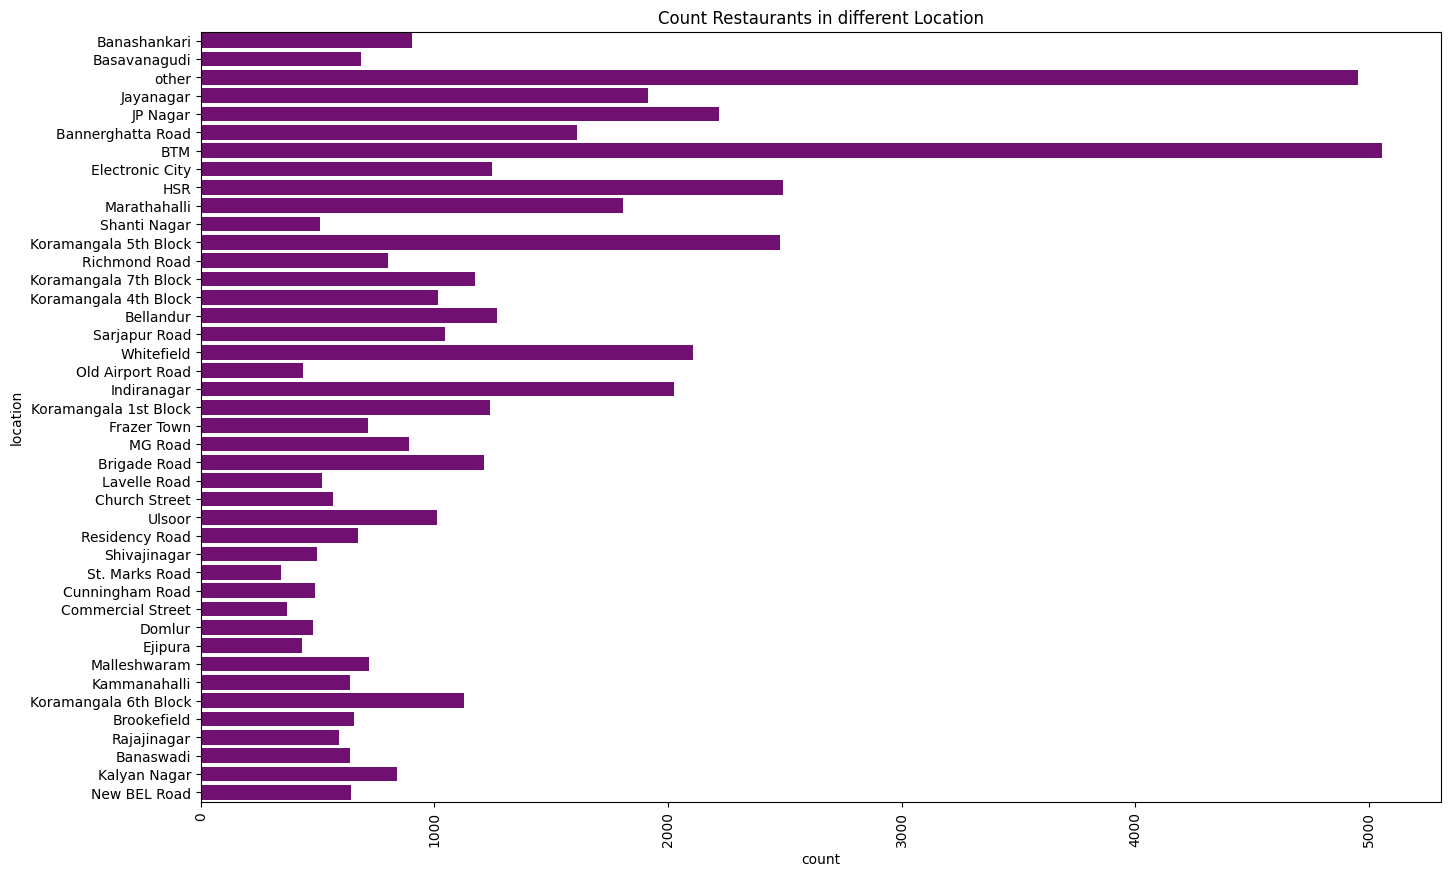

In [ ]:
plt.figure(figsize=(16,10))
sns.countplot(zomato_df['location'],color='purple')
plt.title('Count Restaurants in different Location')
plt.xticks(rotation=90)
plt.show()

Vizualizing Online order

<ipython-input-43-fd0516917e4f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zomato_df['online_order'].value_counts().index,y=zomato_df['online_order'].value_counts(),palette='inferno')


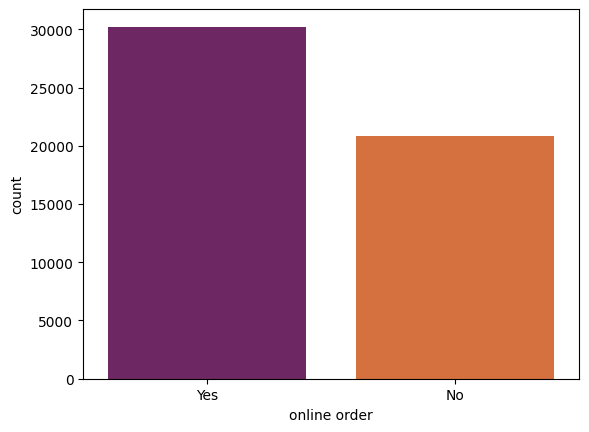

In [ ]:
sns.barplot(x=zomato_df['online_order'].value_counts().index,y=zomato_df['online_order'].value_counts(),palette='inferno')
plt.xlabel('online order')
plt.ylabel('count')
plt.show()

Vizualizing Book Table facilities

<ipython-input-44-51623bceb39b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zomato_df['book_table'].value_counts().index,y=zomato_df['book_table'].value_counts(),palette='rainbow')


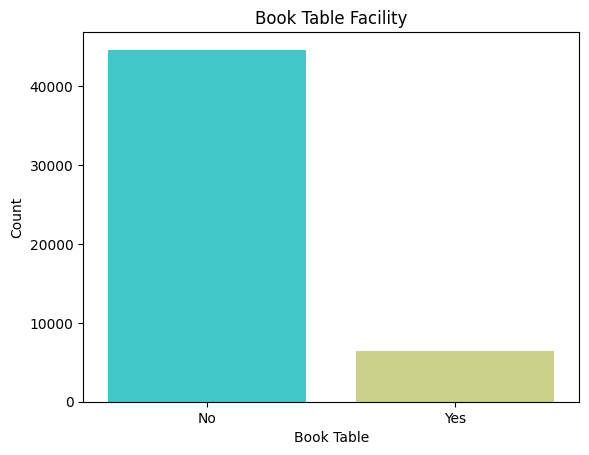

In [ ]:
sns.barplot(x=zomato_df['book_table'].value_counts().index,y=zomato_df['book_table'].value_counts(),palette='rainbow')
plt.title('Book Table Facility')
plt.xlabel('Book Table')
plt.ylabel('Count')
plt.show()

Vizualizing Online_order vs Rate

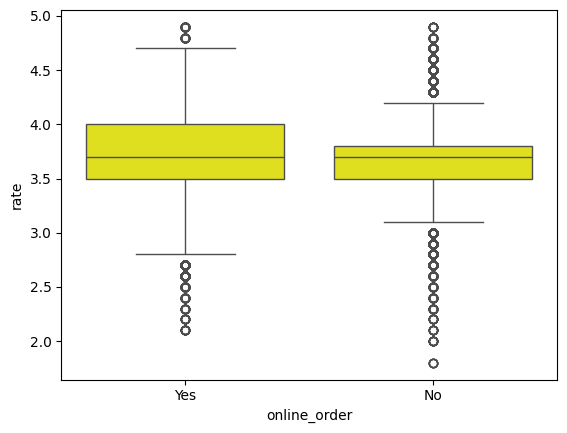

In [ ]:
sns.boxplot(x='online_order',y='rate',data=zomato_df,color='yellow')
plt.show()

Vizualizing Book Table vs Rate

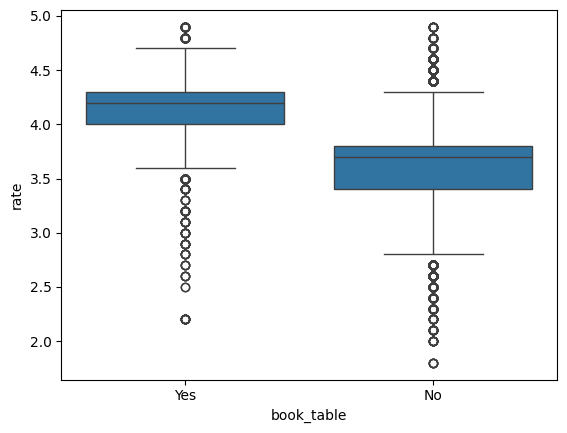

In [ ]:
sns.boxplot(x='book_table',y='rate',data=zomato_df)
plt.show()

Restaurants that have book table facilities have higher average rating than the restaurants don't have.

Visualizing data on online facility and location

In [105]:
df=zomato_df.groupby(['location','online_order'])['name'].count()
df=df.to_csv('location_online.csv')
df=pd.read_csv('location_online.csv')
df=pd.pivot_table(df,index='location',columns='online_order',values=None,aggfunc=np.sum)
df

name      
online_order             No   Yes
location                         
BTM                    1763  3293
Banashankari            397   505
Banaswadi               302   338
Bannerghatta Road       685   924
Basavanagudi            243   441
Bellandur               517   751
Brigade Road            552   658
Brookefield             239   417
Church Street           226   340
Commercial Street       228   142
Cunningham Road         168   322
Domlur                  247   235
Ejipura                 214   219
Electronic City         676   570
Frazer Town             287   427
HSR                     584  1910
Indiranagar             697  1329
JP Nagar                911  1307
Jayanagar               552  1364
Kalyan Nagar            350   491
Kammanahalli            264   375
Koramangala 1st Block   384   852
Koramangala 4th Block   459   558
Koramangala 5th Block   866  1613
Koramangala 6th Block   445   682
Koramangala 7th Block   389   785
Lavelle Road            315   203
MG Road                 520   373
Malleshwaram            309   412
Marathahalli            701  1104
New BEL Road            255   389
Old Airport Road        221   216
Rajajinagar             286   305
Residency Road          424   247
Richmond Road           557   246
Sarjapur Road           323   724
Shanti Nagar            289   219
Shivajinagar            354   144
St. Marks Road          176   167
Ulsoor                  389   622
Whitefield              986  1119
other                  2064  2890

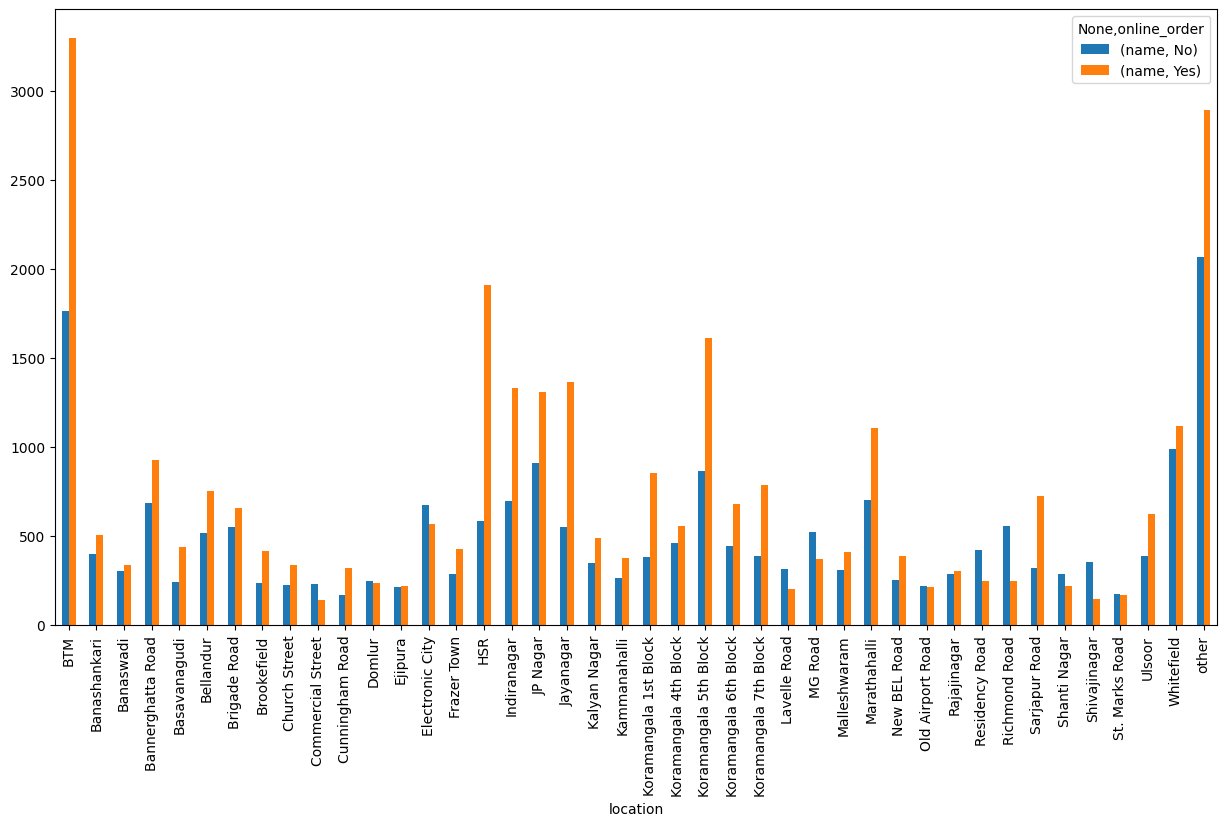

In [106]:
df.plot(kind='bar',figsize=(15,8))
plt.show()

So maximum restaurants located in BTM has the highest number of online order facility,on the other hand restaurants situated in Lavelle road has minimum number of onlin e order facility restaurants.

#Visualizing Book Table facility location wise

In [107]:
df1=zomato_df.groupby(['location','book_table'])['name'].count()
df1=df1.to_csv('location_booktable.csv')
df1=pd.read_csv('location_booktable.csv')
df1=pd.pivot_table(df1,index='location',columns='book_table',values=None,aggfunc=np.sum)
df1

name       
book_table                 No    Yes
location                            
BTM                    4889.0  167.0
Banashankari            839.0   63.0
Banaswadi               632.0    8.0
Bannerghatta Road      1510.0   99.0
Basavanagudi            668.0   16.0
Bellandur              1170.0   98.0
Brigade Road           1034.0  176.0
Brookefield             582.0   74.0
Church Street           385.0  181.0
Commercial Street       370.0    NaN
Cunningham Road         315.0  175.0
Domlur                  427.0   55.0
Ejipura                 433.0    NaN
Electronic City        1148.0   98.0
Frazer Town             706.0    8.0
HSR                    2277.0  217.0
Indiranagar            1578.0  448.0
JP Nagar               1903.0  315.0
Jayanagar              1637.0  279.0
Kalyan Nagar            692.0  149.0
Kammanahalli            590.0   49.0
Koramangala 1st Block  1186.0   50.0
Koramangala 4th Block   695.0  322.0
Koramangala 5th Block  1787.0  692.0
Koramangala 6th Block  1015.0  112.0
Koramangala 7th Block  1012.0  162.0
Lavelle Road            290.0  228.0
MG Road                 546.0  347.0
Malleshwaram            632.0   89.0
Marathahalli           1642.0  163.0
New BEL Road            588.0   56.0
Old Airport Road        378.0   59.0
Rajajinagar             550.0   41.0
Residency Road          522.0  149.0
Richmond Road           687.0  116.0
Sarjapur Road           893.0  154.0
Shanti Nagar            451.0   57.0
Shivajinagar            475.0   23.0
St. Marks Road          219.0  124.0
Ulsoor                  834.0  177.0
Whitefield             1852.0  253.0
other                  4587.0  367.0

In [109]:
df1=df1.fillna(0)

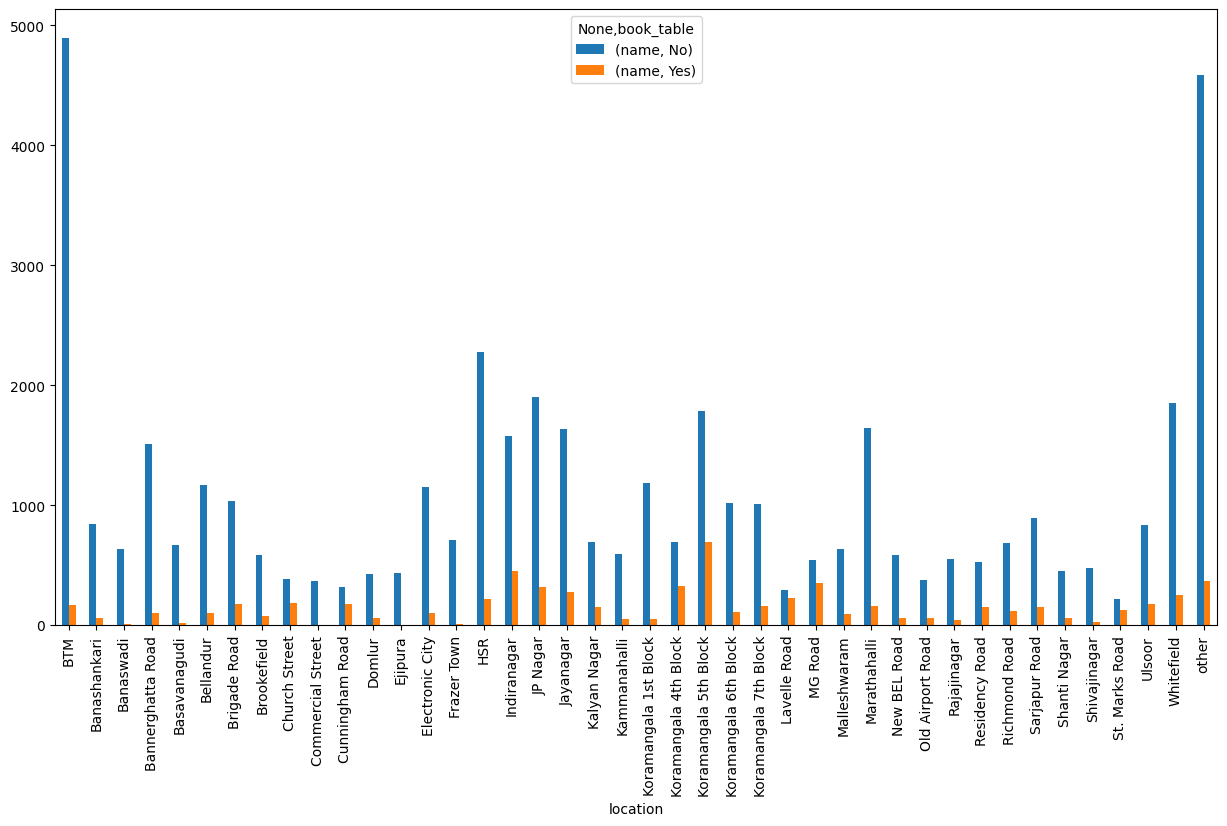

In [110]:
df1.plot(kind='bar',figsize=(15,8))
plt.show()

restaurants situated in BTM do not have Book table facility.

#visualizing type of restaurants vs rate

<ipython-input-111-057fa9728aa9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type',y='rate',data=zomato_df,palette='inferno')


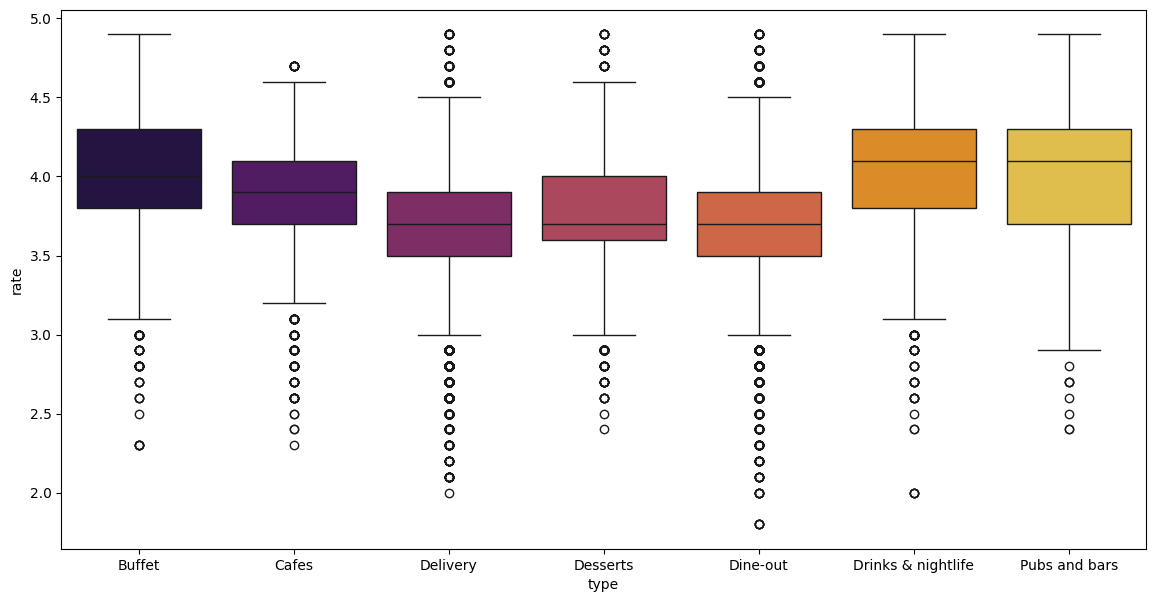

In [111]:
plt.figure(figsize=(14,7))
sns.boxplot(x='type',y='rate',data=zomato_df,palette='inferno')
plt.show()

So maximum average rating has been given to Drinks and nightlife type of restaurants

#Grouping type of restaurants location-wise

In [113]:
df2=zomato_df.groupby(['location','type'])['name'].count()
df2=df2.to_csv('location_type.csv')
df2=pd.read_csv('location_type.csv')
df2=pd.pivot_table(df2,index='location',columns='type',values=None,aggfunc=np.sum)
df2=df2.fillna(0)
df2

name                                    \
type                  Buffet  Cafes Delivery Desserts Dine-out   
location                                                         
BTM                     21.0   83.0   3053.0    198.0   1660.0   
Banashankari             7.0   36.0    418.0     71.0    356.0   
Banaswadi                0.0   24.0    310.0     37.0    262.0   
Bannerghatta Road        9.0   46.0    828.0    137.0    578.0   
Basavanagudi             7.0   11.0    344.0     66.0    251.0   
Bellandur               28.0   36.0    617.0     75.0    479.0   
Brigade Road            25.0   46.0    497.0    108.0    455.0   
Brookefield              6.0   17.0    339.0     45.0    245.0   
Church Street           19.0   51.0    193.0     29.0    215.0   
Commercial Street        0.0   13.0    121.0     77.0    159.0   
Cunningham Road         29.0   34.0    194.0     26.0    184.0   
Domlur                  15.0   13.0    261.0     35.0    135.0   
Ejipura                  0.0    0.0    245.0     16.0    172.0   
Electronic City         23.0   24.0    570.0     71.0    516.0   
Frazer Town              1.0   11.0    470.0     56.0    172.0   
HSR                     19.0   49.0   1694.0    120.0    580.0   
Indiranagar             38.0   97.0   1091.0    140.0    529.0   
JP Nagar                45.0   76.0   1151.0    166.0    722.0   
Jayanagar               27.0   77.0   1043.0    182.0    575.0   
Kalyan Nagar             9.0   45.0    366.0     88.0    315.0   
Kammanahalli             2.0   27.0    329.0     35.0    240.0   
Koramangala 1st Block    3.0   26.0    716.0     70.0    398.0   
Koramangala 4th Block   21.0   53.0    464.0     81.0    302.0   
Koramangala 5th Block   65.0  146.0   1075.0    209.0    842.0   
Koramangala 6th Block   18.0   43.0    511.0     70.0    411.0   
Koramangala 7th Block   25.0   52.0    503.0    127.0    417.0   
Lavelle Road            30.0   27.0    127.0     50.0    191.0   
MG Road                 51.0   76.0    266.0     68.0    343.0   
Malleshwaram            11.0   31.0    269.0     85.0    291.0   
Marathahalli            34.0   32.0    980.0    105.0    630.0   
New BEL Road             4.0   29.0    338.0     33.0    224.0   
Old Airport Road        12.0    5.0    200.0     35.0    164.0   
Rajajinagar             10.0    4.0    258.0     55.0    251.0   
Residency Road          20.0   31.0    187.0     63.0    289.0   
Richmond Road           63.0   21.0    257.0     78.0    356.0   
Sarjapur Road           25.0   22.0    558.0     82.0    319.0   
Shanti Nagar             9.0   22.0    198.0     39.0    229.0   
Shivajinagar             6.0   17.0    143.0     37.0    280.0   
St. Marks Road           5.0   10.0    111.0     10.0    145.0   
Ulsoor                  16.0   56.0    456.0     71.0    359.0   
Whitefield              28.0   51.0   1041.0    137.0    768.0   
other                   83.0  133.0   2787.0    276.0   1553.0   

                                                        
type                  Drinks & nightlife Pubs and bars  
location                                                
BTM                                 22.0          19.0  
Banashankari                        14.0           0.0  
Banaswadi                            6.0           1.0  
Bannerghatta Road                    9.0           2.0  
Basavanagudi                         5.0           0.0  
Bellandur                           17.0          16.0  
Brigade Road                        57.0          22.0  
Brookefield                          4.0           0.0  
Church Street                       36.0          23.0  
Commercial Street                    0.0           0.0  
Cunningham Road                     16.0           7.0  
Domlur                              12.0          11.0  
Ejipura                              0.0           0.0  
Electronic City                     21.0          21.0  
Frazer Town                          2.0           2.0  
HSR                        

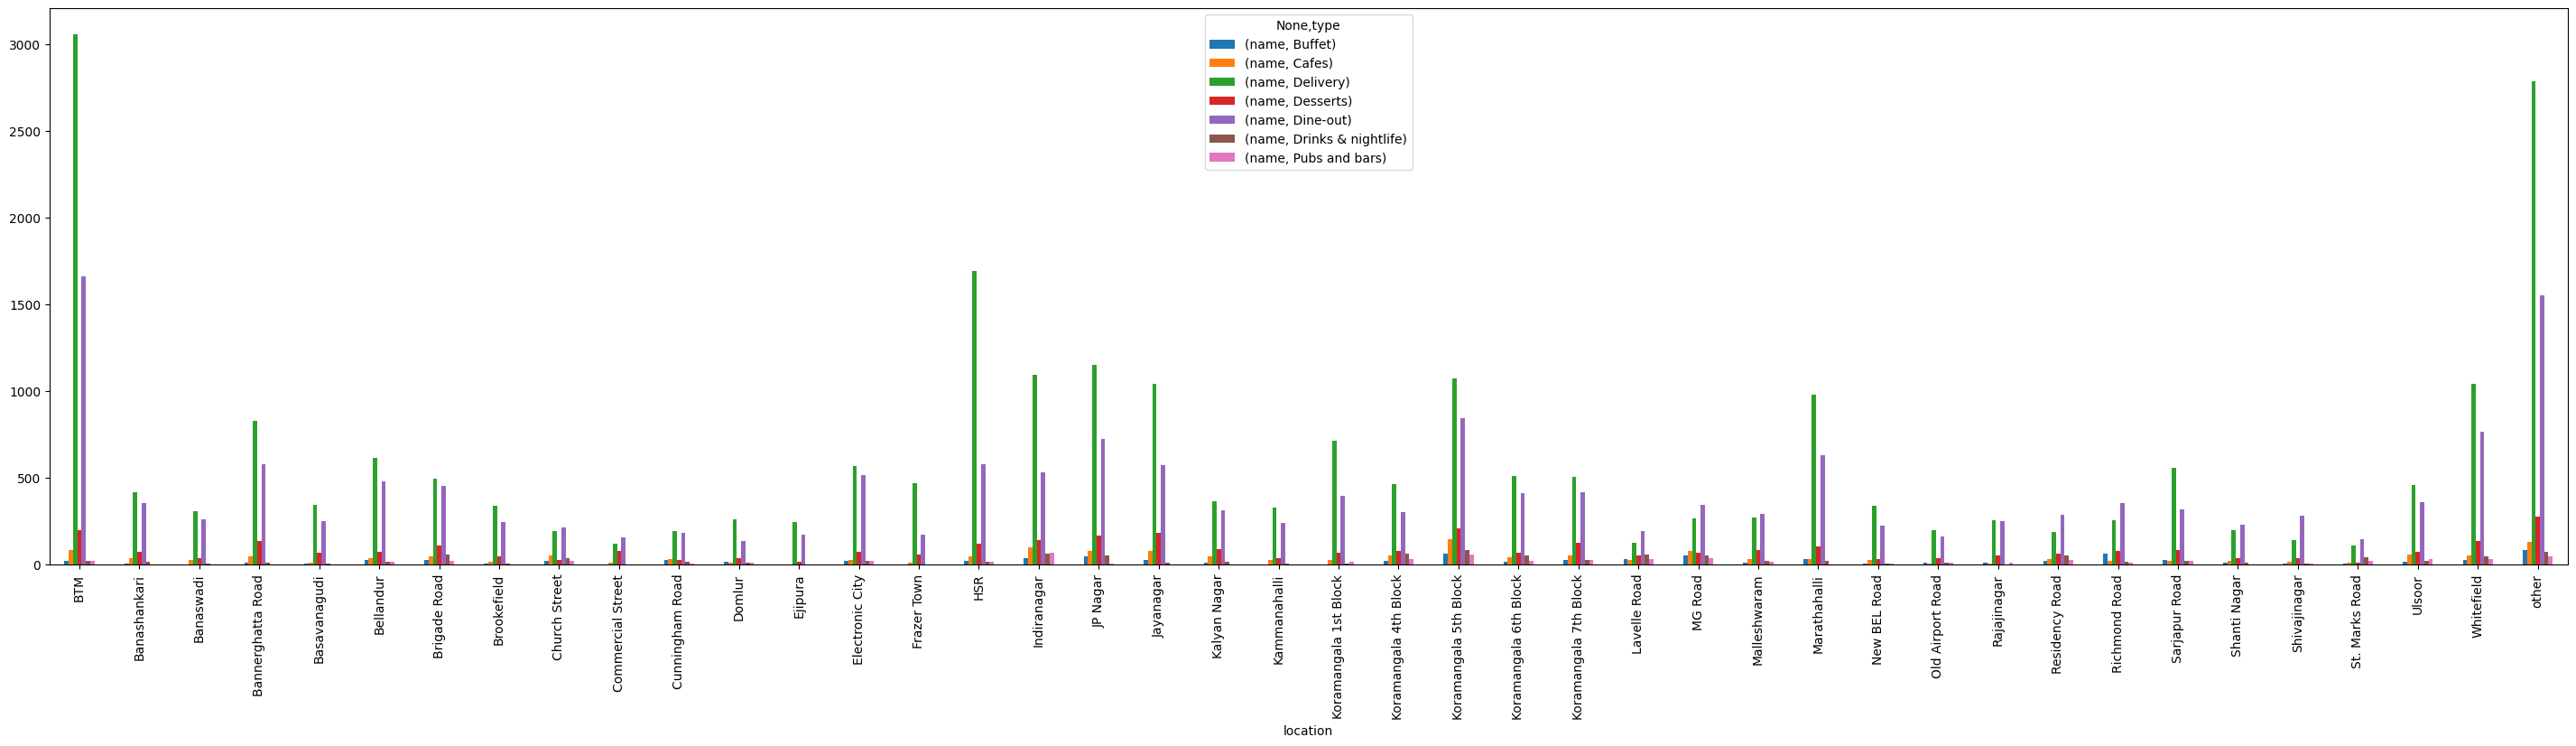

In [114]:
df2.plot(kind='bar',figsize=(36,8))
plt.show()

BTM has highest number of delivery and Dine out restaurants,on the other hand kormangala 5th block has highest number of cafes,desserts and pubs.

#Number of vote locationwise

In [116]:
df3=zomato_df[['location','votes']]
df3=df3.drop_duplicates()
df4=df3.groupby('location')['votes'].sum()
df4=df4.to_frame()
df4=df4.sort_values('votes',ascending=False)
df4

,votes
location,
Koramangala 5th Block,1063061
Indiranagar,648886
Church Street,291543
Koramangala 4th Block,282003
JP Nagar,277901
Jayanagar,265183
Whitefield,237148
HSR,236859
Marathahalli,225746


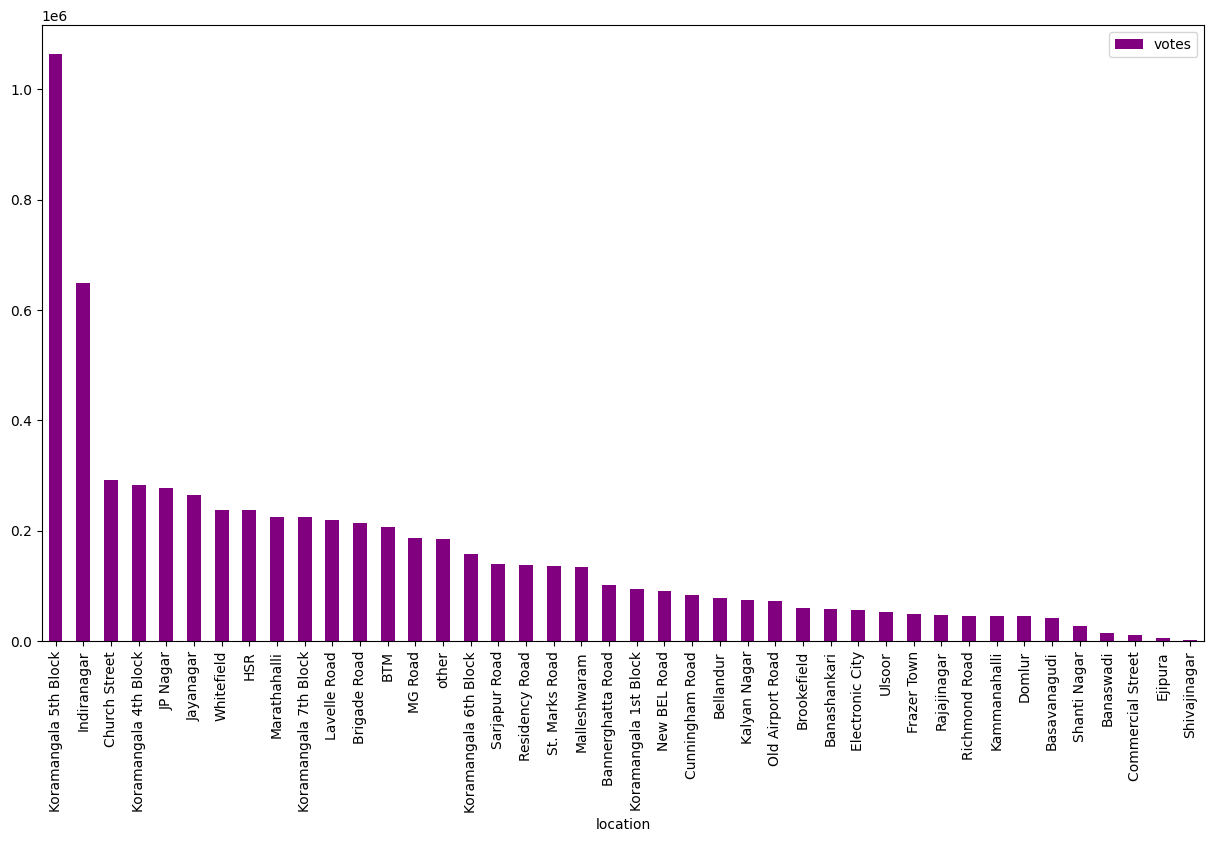

In [125]:
df4.plot(kind='bar',figsize=(15,8),color='purple')
plt.show()

Restaurants which are situated in Kormangala 5th block get the highest number of total votes,followed by the location Indiranagar and church street

#Number of votes cuisines wise

In [123]:
df5=zomato_df[['cuisines','votes']]
df5.drop_duplicates()
df6=df5.groupby('cuisines')['votes'].sum()
df6=df6.to_frame()
df6=df6.sort_values('votes',ascending=False)
df6=df6.iloc[1:,:]
df6=df6[:10] #top 10 cuisins according to the vote

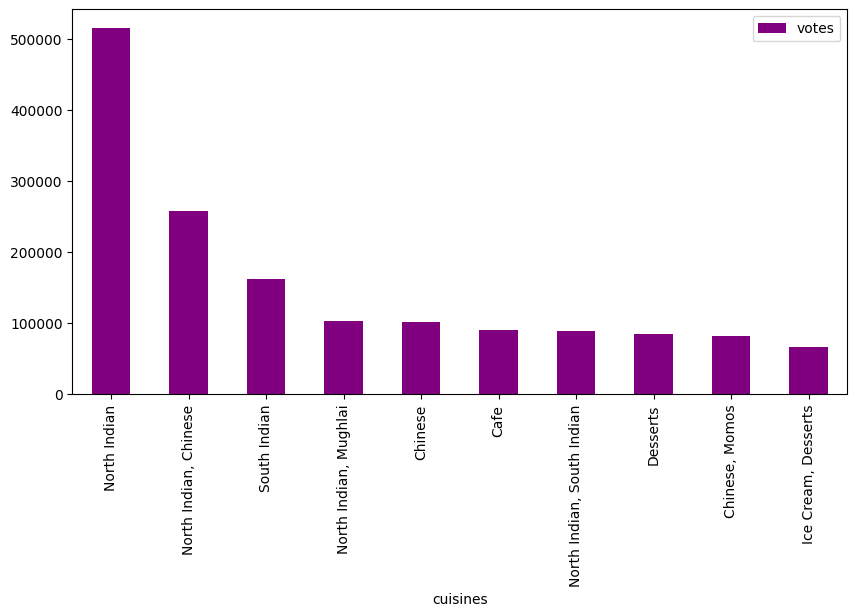

In [124]:
df6.plot(kind='bar',figsize=(10,5),color='purple')
plt.show()

Exceptionally North indian cuisines get maximum number of votes

#So this the the Exploratory Data Analysis of a given dataset from Zomato.

Now we will find out the insights of this analysis and will make some Recommendation on the basis of these insights.

#Insights of the Zomato EDA:-
1.In the location of BTM highest number of Zomato partnered restaurants are situated.

2.Maximum Zomato partnered restaurants have online facility than dine-in.

3.Maximum restaurants do not have book table facility.

4.Restaurants located in Kormangala 4th block have the book table facility in maximum rather than restaurants situated in other location.

5.Drinks and night life type of restaurants have maximum avg rating than other type of restaurants.

6.Restaurants which are located in Kormangala get the highest number of votes,followed by Indiranagar and Church Street.

7.Unexpectedly North Indian Cuisines get maximum number of votes from the people of Bengaluru.

8.The location BTM has the highest number of delivery and dine out type of restaurants and on the other hand Kormangala has the dessertd and cafe type of restaurants in Bengaluru.

9.Restaurants which have Book Table facility have the higher avg rating than the restaurants that don't have.

10.Restaurants who have delivered online orders have slightly higher avg rating.



#RECOMMENDATION:-

1.No restaurant should be opened at BTM to avoid the competition.

2.Lavelli Road doesn't have much restaurants,so new restaurants can be opened there.

3.As Nort Indian foods are popular in Bengaluru so that type of cuisines must be introduced more to reach out more people.

4.For getting higher rating restaurants should apply more Book Table facility.

5.people trust in online delivery more than others,so restaurants should bring more online facility to the people to earn more revenue.

6.As Drinks and night life type restaurants get more rating,it means people love to go to these kind of restaurants,so these type of restaurants should be opened more.